In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pickle
import math
from matplotlib import colors
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency
from statsmodels.tools.eval_measures import aic, bic
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
file_path = Path('data/insurance_train.csv')

In [9]:
df = pd.read_csv(file_path, sep = ',')
df.head()

,reward,claim_status,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
0,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.284509,50b3e71e,51,united states,105.459587,SecurePlan Flex,21
1,18.428627,0,9b2d5b46,type_a,web,0,agt_0001,0.207538,96d6c6df,32,spain,30.433459,DriveSafe Rental Addon,6
2,0.000000,0,9b2d5b46,type_a,web,1,agt_0004,0.300461,50b3e71e,38,new zealand,78.728474,TripGuard Cancel,84
3,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.132404,50b3e71e,30,thailand,17.146843,TripGuard Cancel,39
4,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.070443,50b3e71e,37,viet nam,10.476416,TripGuard Cancel,48


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56993 entries, 0 to 56992
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                56993 non-null  float64
 1   claim_status          56993 non-null  int64  
 2   person_gender         56993 non-null  object 
 3   entity_type           56993 non-null  object 
 4   channel               56993 non-null  object 
 5   support_interactions  56993 non-null  int64  
 6   agent_id              56993 non-null  object 
 7   customer_score        56993 non-null  float64
 8   entity_a              56993 non-null  object 
 9   person_age            56993 non-null  int64  
 10  location              56993 non-null  object 
 11  revenue               56993 non-null  float64
 12  product_id            56993 non-null  object 
 13  trip_length           56993 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 6.1+ MB


In [13]:
columns_with_missings = df.columns[df.isnull().any()]

In [15]:
df[columns_with_missings].isnull().sum()

Series([], dtype: float64)

In [17]:
all_columns = df.columns.tolist()

In [25]:
for column in all_columns:
    print('---------------------------------')
    print(df[column].value_counts(dropna=False))
    print('---------------------------------')

---------------------------------
reward
0.000000     31748
12.567887        1
6.038779         1
7.695268         1
7.879007         1
             ...  
29.769570        1
10.906710        1
79.246733        1
48.532205        1
1.129819         1
Name: count, Length: 25246, dtype: int64
---------------------------------
---------------------------------
claim_status
0    56159
1      834
Name: count, dtype: int64
---------------------------------
---------------------------------
person_gender
9b2d5b46    40643
08f27188     8379
f67ab10a     7971
Name: count, dtype: int64
---------------------------------
---------------------------------
entity_type
type_a    41297
type_b    15696
Name: count, dtype: int64
---------------------------------
---------------------------------
channel
web       56019
retail      974
Name: count, dtype: int64
---------------------------------
---------------------------------
support_interactions
1    21735
0    17115
2    14216
3     3544
4      368
5 

In [21]:
'''
reward - to be dropped as nzv
0.000000     31748
12.567887        1
6.038779         1
7.695268         1

channel - to be dropped as nzv
web       56019
retail      974

customer_score - to be drooped as nzv
0.000000    132
0.284509      1
0.129380      1
0.160595      1
0.330958      1

revenue - to be dropped as nzv
0.000000      1694
105.459587       1
96.652260        1
22.349698        1
58.513046        1
'''

'\nreward - to be dropped as nzv\n0.000000     31748\n12.567887        1\n6.038779         1\n7.695268         1\n\nchannel - to be dropped as nzv\nweb       56019\nretail      974\n\ncustomer_score - to be drooped as nzv\n0.000000    132\n0.284509      1\n0.129380      1\n0.160595      1\n0.330958      1\n\nrevenue - to be dropped as nzv\n0.000000      1694\n105.459587       1\n96.652260        1\n22.349698        1\n58.513046        1\n'

In [23]:
to_drop_nzv = ['reward', 'channel', 'customer_score', 'revenue']

In [27]:
df_categorical_variables = df.select_dtypes('object').columns
df_numerical_variables = df.select_dtypes(include=[np.number]).columns

In [29]:
df_categorical_variables.tolist()

['person_gender',
 'entity_type',
 'channel',
 'agent_id',
 'entity_a',
 'location',
 'product_id']

In [31]:
df_numerical_variables.tolist()

['reward',
 'claim_status',
 'support_interactions',
 'customer_score',
 'person_age',
 'revenue',
 'trip_length']

## Frequency tables for Categorical Variables

In [34]:
for var in df_categorical_variables:
    print('------------------------------')
    print(df[var].value_counts(dropna=False))
    print('------------------------------')

------------------------------
person_gender
9b2d5b46    40643
08f27188     8379
f67ab10a     7971
Name: count, dtype: int64
------------------------------
------------------------------
entity_type
type_a    41297
type_b    15696
Name: count, dtype: int64
------------------------------
------------------------------
channel
web       56019
retail      974
Name: count, dtype: int64
------------------------------
------------------------------
agent_id
agt_0004    31663
agt_0001     7713
agt_0005     7444
agt_0002     5683
agt_0008      949
agt_0006      672
agt_0007      651
agt_0013      612
agt_0015      456
agt_0003      356
agt_0009      297
agt_0011      175
agt_0000       89
agt_0014       85
agt_0010       77
agt_0012       71
Name: count, dtype: int64
------------------------------
------------------------------
entity_a
50b3e71e    31663
96d6c6df     7713
99ede4e4     7444
7b5dbb09     5683
b5e4bb23      949
1e089e14      672
c4e0e538      651
f94f3b95      612
5d630515      4

In [39]:
df_copy = df.copy()

In [36]:
df.shape

(56993, 14)

### Handling Rare Categories in Categorical Variables

To simplify the model and reduce noise from rare levels in categorical variables (e.g., `location`), we apply a threshold to group infrequent categories under a common label `'Other'`.

**Rule Applied:**
- Total rows: 56,993
- Threshold for rare category: 1% of total = ~570
- Any category with **less than 570 occurrences** will be renamed to **`Other`**.

This helps in reducing overfitting and improving model generalization.

In [41]:
for var in df_categorical_variables:
    value_counts = df[var].value_counts()
    levels_to_replace = value_counts[value_counts < 570].index  # 1% of sample size
    df[var] = df[var].replace(levels_to_replace, 'Other')

In [45]:
for var in df_categorical_variables:
    print('-----------------------------------')
    print(df[var].value_counts(dropna=False))
    print('-----------------------------------')

-----------------------------------
person_gender
9b2d5b46    40643
08f27188     8379
f67ab10a     7971
Name: count, dtype: int64
-----------------------------------
-----------------------------------
entity_type
type_a    41297
type_b    15696
Name: count, dtype: int64
-----------------------------------
-----------------------------------
channel
web       56019
retail      974
Name: count, dtype: int64
-----------------------------------
-----------------------------------
agent_id
agt_0004    31663
agt_0001     7713
agt_0005     7444
agt_0002     5683
Other        1606
agt_0008      949
agt_0006      672
agt_0007      651
agt_0013      612
Name: count, dtype: int64
-----------------------------------
-----------------------------------
entity_a
50b3e71e    31663
96d6c6df     7713
99ede4e4     7444
7b5dbb09     5683
Other        1606
b5e4bb23      949
1e089e14      672
c4e0e538      651
f94f3b95      612
Name: count, dtype: int64
-----------------------------------
----------------

## Near Zero Variance

In [54]:
def near_zero_variance(df, freq_cut=95/5, unique_cut=10):
    results = []
    for col in df.columns:
        counts = df[col].value_counts()
        if len(counts) > 1:
            freq_ratio = counts.iloc[0] / counts.iloc[1]
        else:
            freq_ratio = float('inf')  # only one unique value

        unique_ratio = len(counts) / len(df)
        high_freq_ratio = int(freq_ratio > freq_cut)
        low_unique_ratio = int(unique_ratio < unique_cut)

        results.append({
            'variable': col,
            'freq_ratio': freq_ratio,
            'unique_ratio': unique_ratio,
            'high_freq_ratio': high_freq_ratio,
            'low_unique_ratio': low_unique_ratio
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['freq_ratio', 'unique_ratio'], ascending=[False, True])
    return results_df


In [56]:
df_nzv = near_zero_variance(df, freq_cut=90/10, unique_cut=0.05)
df_nzv[(df_nzv['low_unique_ratio'] == 1) & (df_nzv['high_freq_ratio'] == 1)]

,variable,freq_ratio,unique_ratio,high_freq_ratio,low_unique_ratio
1,claim_status,67.336930,0.000035,1,1
4,channel,57.514374,0.000035,1,1


### `claim_status` is Target variable

### Near-Zero Variance (NZV) Analysis

We applied an NZV detection function to the dataset, which flagged only two variables:

- `claim_status`
- `channel`

However, upon manual inspection using frequency tables, additional variables showed dominant single values and low variability:

- `reward`: 0 in >31k rows
- `customer_score`: 0 in 132 rows, rest nearly unique
- `revenue`: 0 dominates, others are rare

These were **not** flagged due to the function relying solely on frequency and unique ratios. We've updated the logic to also consider **top value dominance** to better capture such cases.


In [69]:
df_copy = df.copy()

In [81]:
to_drop_nzv

['reward', 'channel', 'customer_score', 'revenue']

In [79]:
df.drop(to_drop_nzv, axis=1, inplace = True)

## Train - Test Split

In [84]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45594 entries, 40310 to 56422
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   claim_status          45594 non-null  int64 
 1   person_gender         45594 non-null  object
 2   entity_type           45594 non-null  object
 3   support_interactions  45594 non-null  int64 
 4   agent_id              45594 non-null  object
 5   entity_a              45594 non-null  object
 6   person_age            45594 non-null  int64 
 7   location              45594 non-null  object
 8   product_id            45594 non-null  object
 9   trip_length           45594 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 3.8+ MB


In [88]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11399 entries, 23015 to 56921
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   claim_status          11399 non-null  int64 
 1   person_gender         11399 non-null  object
 2   entity_type           11399 non-null  object
 3   support_interactions  11399 non-null  int64 
 4   agent_id              11399 non-null  object
 5   entity_a              11399 non-null  object
 6   person_age            11399 non-null  int64 
 7   location              11399 non-null  object
 8   product_id            11399 non-null  object
 9   trip_length           11399 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 979.6+ KB


In [261]:
all_variables = df_train.columns.tolist()

In [96]:
for var in all_variables:
    print('-------------------------------') 
    print(df_train[var].value_counts(dropna=False))
    print('-------------------------------')

-------------------------------
claim_status
0    44914
1      680
Name: count, dtype: int64
-------------------------------
-------------------------------
person_gender
9b2d5b46    32537
08f27188     6663
f67ab10a     6394
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_type
type_a    33035
type_b    12559
Name: count, dtype: int64
-------------------------------
-------------------------------
support_interactions
1    17391
0    13717
2    11320
3     2851
4      301
5       13
6        1
Name: count, dtype: int64
-------------------------------
-------------------------------
agent_id
agt_0004    25270
agt_0001     6236
agt_0005     5926
agt_0002     4532
Other        1291
agt_0008      774
agt_0006      567
agt_0007      511
agt_0013      487
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_a
50b3e71e    25270
96d6c6df     6236
99ede4e4     5926
7b5dbb09     4532
Other        1291
b5e

### Distribution of the Target variable

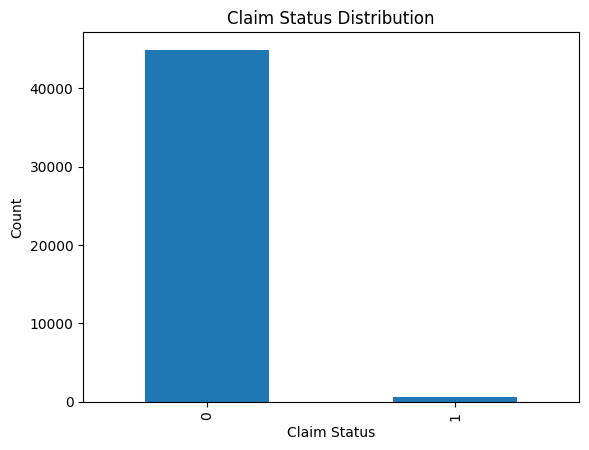

In [112]:
df_train['claim_status'].value_counts().plot(kind='bar')
plt.title('Claim Status Distribution')
plt.xlabel('Claim Status')
plt.ylabel('Count')
plt.show()

In [116]:
categorical_variables = df_train.select_dtypes('object').columns
numerical_variables = df_train.select_dtypes(include=[np.number]).columns

In [122]:
print(categorical_variables)

Index(['person_gender', 'entity_type', 'agent_id', 'entity_a', 'location',
       'product_id'],
      dtype='object')


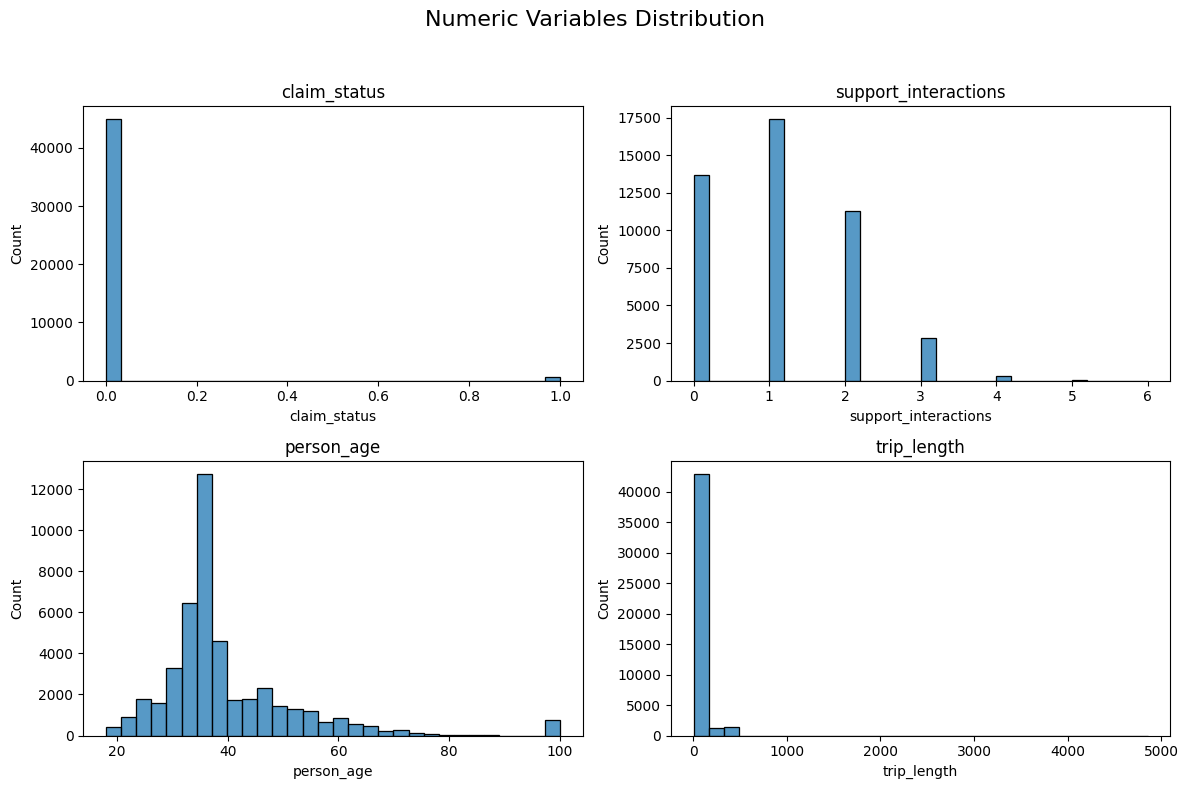

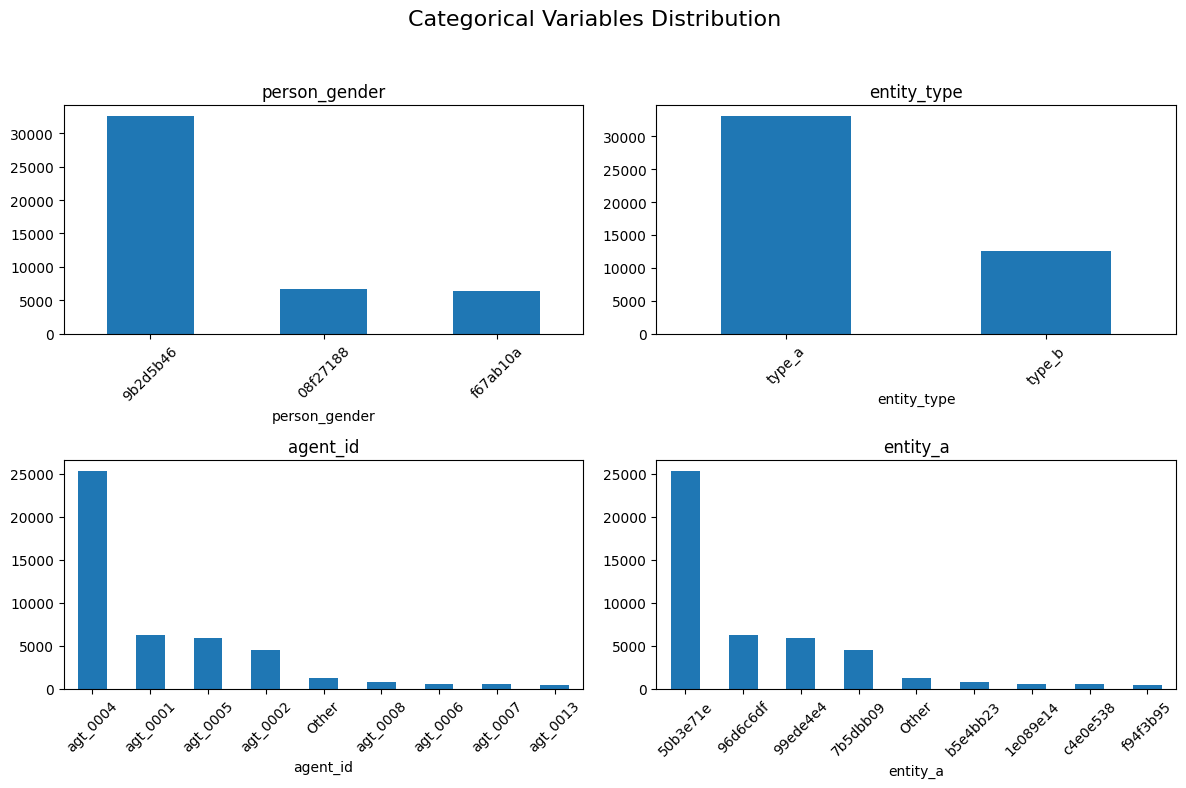

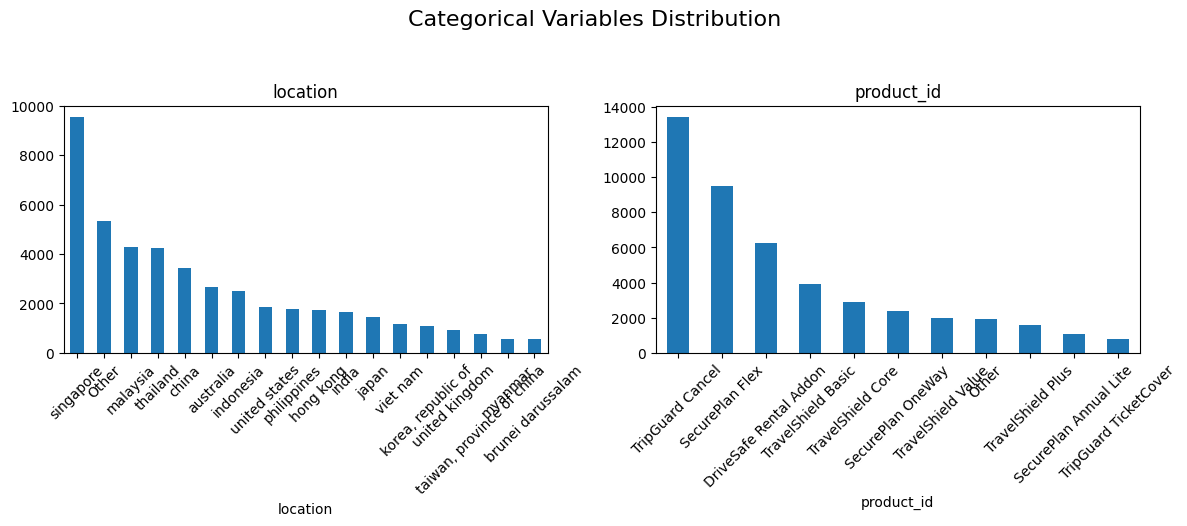

In [126]:
def plot_in_batches(df, columns, plot_func, plot_title, batch_size=4):
    total = len(columns)
    batches = math.ceil(total / batch_size)

    for b in range(batches):
        plt.figure(figsize=(12, 8))
        plt.suptitle(plot_title, fontsize=16)
        batch_cols = columns[b*batch_size:(b+1)*batch_size]

        for i, col in enumerate(batch_cols, 1):
            plt.subplot(2, 2, i)
            plot_func(df, col)
            plt.title(col)
            if plot_func == plot_categorical:
                plt.xticks(rotation=45)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

def plot_numeric(df, col):
    sns.histplot(df[col], kde=False, bins=30)

def plot_categorical(df, col):
    df[col].value_counts().plot(kind='bar')
    
plot_in_batches(df_train, numerical_variables, plot_numeric, 'Numeric Variables Distribution')

plot_in_batches(df_train, categorical_variables, plot_categorical, 'Categorical Variables Distribution')

# Feature Selection

### Numerical Correlations

In [128]:
numerical_variables

Index(['claim_status', 'support_interactions', 'person_age', 'trip_length'], dtype='object')

In [133]:
numeric_correlations = df_train[numerical_variables].corr(method='pearson')
numeric_correlations

,claim_status,support_interactions,person_age,trip_length
claim_status,1.000000,0.004577,-0.012020,0.084758
support_interactions,0.004577,1.000000,0.004911,0.045944
person_age,-0.012020,0.004911,1.000000,0.004083
trip_length,0.084758,0.045944,0.004083,1.000000


<Axes: >

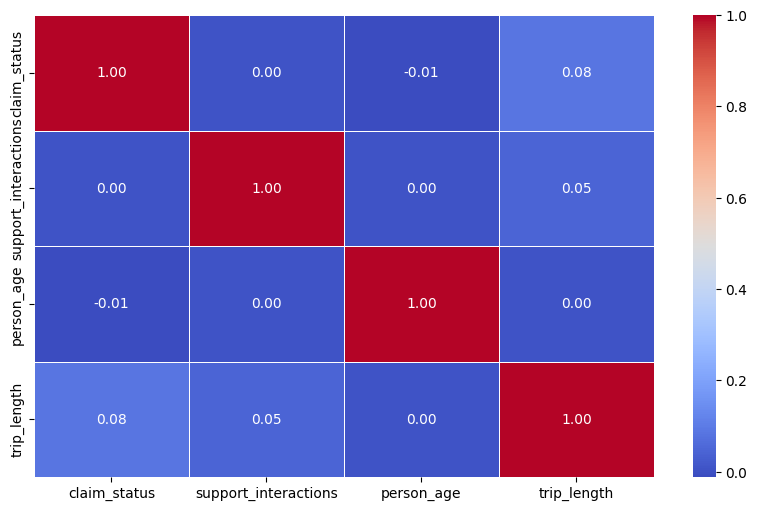

In [143]:
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_correlations,
            annot = True, 
            cmap = 'coolwarm', 
            fmt = '.2f',
            linewidths = 0.5)

In [145]:
mask = np.triu(np.ones_like(numeric_correlations, dtype=bool))
correlation_with_target = numeric_correlations.claim_status.sort_values(ascending=False)
ordered_columns = correlation_with_target.index
numeric_correlations=numeric_correlations[ordered_columns].loc[ordered_columns]

<Axes: >

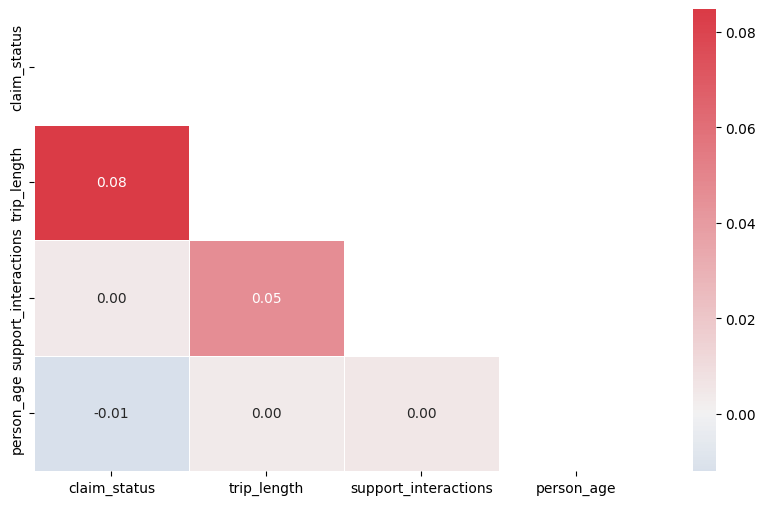

In [149]:
my_cmap = sns.diverging_palette(250, 10, as_cmap = True)
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_correlations,
           annot = True,
           cmap = my_cmap,
           mask = mask,
           fmt = '.2f',
           linewidths = 0.5,
           # this argument ensures that the color map is centered at 0, 
           # meaning 0 will be displayed in white
           center = 0)

### MY OWN MISTAKE

I used pearson correlation for Y binary and X numeric one, i had to use ANOVA, now i will do it again, but plots look nice hence decided to leave.

In [155]:
def anova_for_categorical_vars(dataset, dependent_var, categorical_vars):
    results = []
    for var in categorical_vars:
        model = smf.ols(f'{dependent_var} ~ C({var})', data = dataset).fit()
        anova_table = anova_lm(model)
        f_statistic = anova_table['F'].iloc[0]
        p_value = anova_table['PR(>F)'].iloc[0]
        results.append([var, f_statistic, p_value])
        
    anova_results_df = pd.DataFrame(results,
                                   columns = ['Variable', 'F-statistic', 'p-values'])
    anova_results_df = anova_results_df.sort_values(by = 'F-statistic', ascending = False)
    
    return anova_results_df

In [175]:
anova_results = anova_for_categorical_vars(df_train,
                                             'claim_status', numerical_variables)

In [165]:
# The F statistic is used to verify the null hypothesis that:
# H0: Park does NOT impact the Price
# Our Result shows that having park affects the price of an appartment
# The higher the F-statistic (or the lower its p-value) the stronger we reject H0

In [163]:
print(anova_results)

               Variable   F-statistic       p-values
0          claim_status  4.858563e+32   0.000000e+00
3           trip_length  3.694421e+00  3.934678e-129
2            person_age  2.923649e+00   1.222365e-15
1  support_interactions  8.211892e-01   5.531985e-01


In [167]:
anova_results.head()

,Variable,F-statistic,p-values
0,claim_status,4.858563e+32,0.000000e+00
3,trip_length,3.694421e+00,3.934678e-129
2,person_age,2.923649e+00,1.222365e-15
1,support_interactions,8.211892e-01,5.531985e-01


In [177]:
anova_results['p-values'] = anova_results['p-values'].apply(lambda x: f"{x:.2e}" if x < 1e-3 else f"{x:.2f}")
print(anova_results)

               Variable   F-statistic   p-values
0          claim_status  4.858563e+32   0.00e+00
3           trip_length  3.694421e+00  3.93e-129
2            person_age  2.923649e+00   1.22e-15
1  support_interactions  8.211892e-01       0.55


---
`support_interactions` Not significant – likely no useful impact on the target

---

In [187]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [183]:
df_train.drop(['support_interactions'], axis=1, inplace=True)

In [185]:
df_test.drop(['support_interactions'], axis=1, inplace=True)

In [240]:
categorical_variables = df_train.select_dtypes('object').columns
numerical_variables = df_train.select_dtypes(include=[np.number]).columns

## Anova Results for Y (Numeric) and X (Categorical)

In [250]:
anova_results = anova_for_categorical_vars(df_train,
                                             'claim_status', categorical_variables)

In [252]:
print(anova_results)

        Variable  F-statistic       p-values
1    entity_type   478.806549  1.361019e-105
0  person_gender   286.177454  3.078851e-124
3       entity_a   176.886875  1.325288e-295
2       agent_id   176.886875  1.325288e-295
5     product_id   159.406573   0.000000e+00
4       location    41.197153  9.386148e-137


In [254]:
anova_results.head()

,Variable,F-statistic,p-values
1,entity_type,478.806549,1.361019e-105
0,person_gender,286.177454,3.078851e-124
3,entity_a,176.886875,1.325288e-295
2,agent_id,176.886875,1.325288e-295
5,product_id,159.406573,0.000000e+00


In [256]:
anova_results['p-values'] = anova_results['p-values'].apply(lambda x: f"{x:.2e}" if x < 1e-3 else f"{x:.2f}")
print(anova_results)

        Variable  F-statistic   p-values
1    entity_type   478.806549  1.36e-105
0  person_gender   286.177454  3.08e-124
3       entity_a   176.886875  1.33e-295
2       agent_id   176.886875  1.33e-295
5     product_id   159.406573   0.00e+00
4       location    41.197153  9.39e-137


### ANOVA Results: Association Between Target (`claim_status`) and Categorical Variables

| Variable      | F-statistic | p-value           | Interpretation                          |
|---------------|-------------|-------------------|---------------------------------------|
| entity_type   | 478.81      | 1.36e-105         | Very strong association (significant) |
| person_gender | 286.18      | 3.08e-124         | Very strong association (significant) |
| entity_a      | 176.89      | 1.33e-295         | Very strong association (significant) |
| agent_id      | 176.89      | 1.33e-295         | Very strong association (significant) |
| product_id    | 159.41      | 0.00              | Very strong association (significant) |

**Summary:**  
All tested categorical variables show highly significant differences in `claim_status` distributions across their categories, indicating they are important predictors for the model.


In [263]:
for var in all_variables:
    print('-------------------------------') 
    print(df_train[var].value_counts(dropna=False))
    print('-------------------------------')

-------------------------------
claim_status
0    44914
1      680
Name: count, dtype: int64
-------------------------------
-------------------------------
person_gender
9b2d5b46    32537
08f27188     6663
f67ab10a     6394
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_type
type_a    33035
type_b    12559
Name: count, dtype: int64
-------------------------------
-------------------------------
agent_id
agt_0004    25270
agt_0001     6236
agt_0005     5926
agt_0002     4532
Other        1291
agt_0008      774
agt_0006      567
agt_0007      511
agt_0013      487
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_a
50b3e71e    25270
96d6c6df     6236
99ede4e4     5926
7b5dbb09     4532
Other        1291
b5e4bb23      774
1e089e14      567
c4e0e538      511
f94f3b95      487
Name: count, dtype: int64
-------------------------------
-------------------------------
person_age
36    4301
34    4

In [297]:
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [299]:
print(df_train.trip_length.value_counts())

trip_length
7      1471
6      1434
4      1388
5      1362
8      1361
       ... 
440       1
486       1
510       1
348       1
468       1
Name: count, Length: 431, dtype: int64


<Axes: xlabel='trip_length', ylabel='Count'>

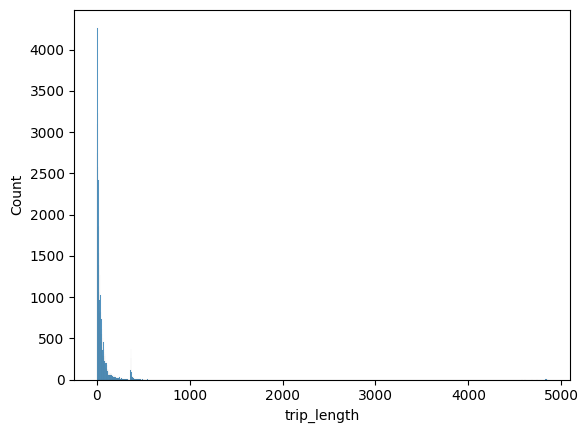

In [289]:
sns.histplot(df_train.trip_length)

In [301]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [334]:
# df_train_copy.trip_length.value_counts()

In [340]:
# df_train = df_train_copy.copy()
# df_test = df_test_copy.copy()

In [342]:
# Group agent_id & entity_a with counts < 500 into 'Other'
for col in ['agent_id', 'entity_a']:
    counts = df_train[col].value_counts()
    to_other = counts[counts < 500].index
    df_train[col] = df_train[col].replace(to_other, 'Other')
    df_test[col] = df_test[col].replace(to_other, 'Other')

In [344]:
# Bin person_age 60+ into '60+'
df_train['person_age'] = df_train['person_age'].apply(lambda x: '60+' if x >= 60 else x)
df_test['person_age'] = df_test['person_age'].apply(lambda x: '60+' if x >= 60 else x)

In [346]:
# Group location with counts < 900 (from 'united kingdom' down) into 'Other'
loc_counts = df_train['location'].value_counts()
loc_to_other = loc_counts[loc_counts < 900].index
df_train['location'] = df_train['location'].replace(loc_to_other, 'Other')
df_test['location'] = df_test['location'].replace(loc_to_other, 'Other')

In [348]:
# Group product_id with counts < 1000 into 'Other'
prod_counts = df_train['product_id'].value_counts()
prod_to_other = prod_counts[prod_counts < 1000].index
df_train['product_id'] = df_train['product_id'].replace(prod_to_other, 'Other')
df_test['product_id'] = df_test['product_id'].replace(prod_to_other, 'Other')

In [350]:
def bin_trip_length(x):
    if x > 90:
        return '90+'
    elif 1 <= x <= 60:
        return x
    else:
        # For zero or invalid trip lengths, decide what to do, e.g.:
        return x  # or return np.nan if you want to treat them as missing

In [352]:
df_train['trip_length'] = df_train['trip_length'].apply(bin_trip_length)
df_test['trip_length'] = df_test['trip_length'].apply(bin_trip_length)

In [354]:
for var in all_variables:
    print('-------------------------------') 
    print(df_train[var].value_counts(dropna=False))
    print('-------------------------------')

-------------------------------
claim_status
0    44914
1      680
Name: count, dtype: int64
-------------------------------
-------------------------------
person_gender
9b2d5b46    32537
08f27188     6663
f67ab10a     6394
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_type
type_a    33035
type_b    12559
Name: count, dtype: int64
-------------------------------
-------------------------------
agent_id
agt_0004    25270
agt_0001     6236
agt_0005     5926
agt_0002     4532
Other        1778
agt_0008      774
agt_0006      567
agt_0007      511
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_a
50b3e71e    25270
96d6c6df     6236
99ede4e4     5926
7b5dbb09     4532
Other        1778
b5e4bb23      774
1e089e14      567
c4e0e538      511
Name: count, dtype: int64
-------------------------------
-------------------------------
person_age
36     4301
34     4272
35     4253
37     4161
38    

In [319]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45594 entries, 40310 to 56422
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim_status   45594 non-null  int64 
 1   person_gender  45594 non-null  object
 2   entity_type    45594 non-null  object
 3   agent_id       45594 non-null  object
 4   entity_a       45594 non-null  object
 5   person_age     45594 non-null  object
 6   location       45594 non-null  object
 7   product_id     45594 non-null  object
 8   trip_length    45594 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.5+ MB


In [321]:
numerical_variables

Index(['claim_status', 'person_age', 'trip_length'], dtype='object')

## Data Binning and Encoding Decisions

For the variables **person_age** and **trip_length**, I applied binning to handle sparse and extreme values effectively:

- For **person_age**, I grouped all ages 60 and above into a single bin labeled `"60+"`.
- For **trip_length**, I kept values from 1 to 60 as-is, and grouped values above 90 or rare outliers into a bin labeled `"90+"`.

Since this binning converted numeric variables into categorical-like strings, I faced the choice of how to handle these bins before modeling. Instead of keeping `"60+"` and `"90+"` as strings (which would require one-hot encoding and increase feature dimensionality), I decided to:

- Replace `"60+"` with the numeric value `60`
- Replace `"90+"` with the numeric value `90`

### Why this approach?

- **Maintain numeric type:** Models like Logistic Regression, KNN, and SVM perform better with numeric inputs and can naturally interpret ordinal relationships.
- **Preserve ordering:** Assigning 60 and 90 to these bins preserves the approximate magnitude and order of the values.
- **Avoid dimensionality explosion:** Encoding these as categories would increase the number of features unnecessarily.
- **Simplify modeling:** This approach provides a clean, interpretable numeric variable without losing meaningful information from binning.

Overall, this balances the benefits of binning sparse/extreme values and maintaining numeric input format for efficient and effective modeling.


In [356]:
# Replace '60+' with 60 and convert to numeric
df_train['person_age'] = df_train['person_age'].replace('60+', 60).astype(int)
df_test['person_age'] = df_test['person_age'].replace('60+', 60).astype(int)

# Replace '90+' with 90 and convert to numeric
df_train['trip_length'] = df_train['trip_length'].replace('90+', 90).astype(int)
df_test['trip_length'] = df_test['trip_length'].replace('90+', 90).astype(int)

In [358]:
for var in all_variables:
    print('-------------------------------') 
    print(df_train[var].value_counts(dropna=False))
    print('-------------------------------')

-------------------------------
claim_status
0    44914
1      680
Name: count, dtype: int64
-------------------------------
-------------------------------
person_gender
9b2d5b46    32537
08f27188     6663
f67ab10a     6394
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_type
type_a    33035
type_b    12559
Name: count, dtype: int64
-------------------------------
-------------------------------
agent_id
agt_0004    25270
agt_0001     6236
agt_0005     5926
agt_0002     4532
Other        1778
agt_0008      774
agt_0006      567
agt_0007      511
Name: count, dtype: int64
-------------------------------
-------------------------------
entity_a
50b3e71e    25270
96d6c6df     6236
99ede4e4     5926
7b5dbb09     4532
Other        1778
b5e4bb23      774
1e089e14      567
c4e0e538      511
Name: count, dtype: int64
-------------------------------
-------------------------------
person_age
36    4301
34    4272
35    4253
37    4161
38    3993

In [360]:
categorical_variables = df_train.select_dtypes('object').columns
numerical_variables = df_train.select_dtypes(include=[np.number]).columns

In [363]:
df_train.head()

,claim_status,person_gender,entity_type,agent_id,entity_a,person_age,location,product_id,trip_length
40310,0,f67ab10a,type_b,agt_0002,7b5dbb09,54,Other,TravelShield Basic,66
31436,0,08f27188,type_a,Other,Other,24,malaysia,Other,3
6845,0,9b2d5b46,type_a,agt_0004,50b3e71e,35,indonesia,SecurePlan Flex,62
7916,0,9b2d5b46,type_a,agt_0004,50b3e71e,37,malaysia,TripGuard Cancel,4
46039,0,9b2d5b46,type_a,agt_0004,50b3e71e,42,thailand,TripGuard Cancel,17


## Logit Model

In [367]:
# simple logit with only numeric predictors
logit1 = smf.logit(
    formula = 'claim_status ~ person_age + trip_length', data = df_train
).fit()

Optimization terminated successfully.
         Current function value: 0.075972
         Iterations 8


In [369]:
print(logit1.summary())

                           Logit Regression Results                           
Dep. Variable:           claim_status   No. Observations:                45594
Model:                          Logit   Df Residuals:                    45591
Method:                           MLE   Df Model:                            2
Date:                Fri, 30 May 2025   Pseudo R-squ.:                 0.02002
Time:                        23:06:30   Log-Likelihood:                -3463.8
converged:                       True   LL-Null:                       -3534.6
Covariance Type:            nonrobust   LLR p-value:                 1.865e-31
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.2792      0.173    -24.686      0.000      -4.619      -3.939
person_age     -0.0122      0.004     -2.902      0.004      -0.021      -0.004
trip_length     0.0138      0.001     11.731    

In [401]:
categorical_variables

Index(['person_gender', 'entity_type', 'agent_id', 'entity_a', 'location',
       'product_id'],
      dtype='object')

In [405]:
X_train = df_train.drop(
    ['claim_status', 'person_gender', 'entity_type', 'agent_id',
     'entity_a', 'location', 'product_id'], axis=1
)
y_train = df_train['claim_status']

In [407]:
y_pred = logit1.predict(X_train)

In [409]:
rmse = np.sqrt(mean_squared_error(df_train['claim_status'], y_pred))

mae = mean_absolute_error(df_train['claim_status'], y_pred)

medae = median_absolute_error(df_train['claim_status'], y_pred)

print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Median Absolute Error:', medae)

Mean Absolute Error: 0.029280360299477375
Root Mean Squared Error: 0.12099472069111106
Median Absolute Error: 0.011912109615225585


In [411]:
X_train  # i have already
y_train  # i have already

logit_model1 = LogisticRegression(
    penalty=None
)

logit_model1.fit(X_train, y_train)

LogisticRegression(penalty=None)

In [413]:
logit_model1.predict_proba(X_train)

array([[0.9825467 , 0.0174533 ],
       [0.98935157, 0.01064843],
       [0.97922984, 0.02077016],
       ...,
       [0.9870912 , 0.0129088 ],
       [0.99292847, 0.00707153],
       [0.98620569, 0.01379431]])

In [415]:
# how to extract predicted probabilities of account_status = closed (1)?
y_pred_probs = logit_model1.predict_proba(X_train)[:, 1]  # to extract column 1 which is level 1 from predictions


# if one just wants to predict the class (for default cutoff = 0.5), 
# one can use the method .predict()
y_pred = logit_model1.predict(X_train)


# calculate the confussion matrix
cm = confusion_matrix(df_train['claim_status'], y_pred)


# calculate the false positive rate and the true positive rate
fpr, tpr, _ = roc_curve(df_train['claim_status'], y_pred_probs)
# y_true: True binary labels
# y_score: Target scores - probability estimates of the positive class


# calculate the area under the curve
roc_auc = auc(fpr, tpr)

print('Confusion Matrix:')
print(cm)

print('Area Under the Curve:', roc_auc)

Confusion Matrix:
[[44914     0]
 [  680     0]]
Area Under the Curve: 0.6297479300309874


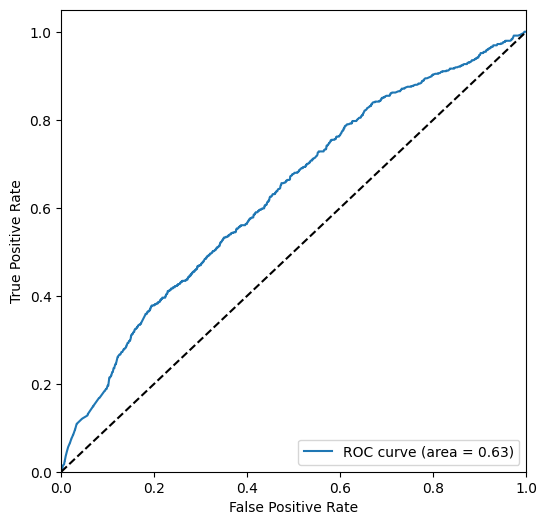

In [417]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Time for Encoding

In [420]:
df_train[categorical_variables]

,person_gender,entity_type,agent_id,entity_a,location,product_id
40310,f67ab10a,type_b,agt_0002,7b5dbb09,Other,TravelShield Basic
31436,08f27188,type_a,Other,Other,malaysia,Other
6845,9b2d5b46,type_a,agt_0004,50b3e71e,indonesia,SecurePlan Flex
7916,9b2d5b46,type_a,agt_0004,50b3e71e,malaysia,TripGuard Cancel
46039,9b2d5b46,type_a,agt_0004,50b3e71e,thailand,TripGuard Cancel
...,...,...,...,...,...,...
54343,9b2d5b46,type_a,agt_0001,96d6c6df,united kingdom,DriveSafe Rental Addon
38158,9b2d5b46,type_a,agt_0004,50b3e71e,singapore,TripGuard Cancel
860,f67ab10a,type_b,agt_0005,99ede4e4,singapore,TravelShield Core
15795,f67ab10a,type_b,agt_0002,7b5dbb09,indonesia,TravelShield Value


In [422]:
for var in categorical_variables:
    print('---------------------------------')
    print(df_train[var].value_counts(dropna=False))
    print('---------------------------------')

---------------------------------
person_gender
9b2d5b46    32537
08f27188     6663
f67ab10a     6394
Name: count, dtype: int64
---------------------------------
---------------------------------
entity_type
type_a    33035
type_b    12559
Name: count, dtype: int64
---------------------------------
---------------------------------
agent_id
agt_0004    25270
agt_0001     6236
agt_0005     5926
agt_0002     4532
Other        1778
agt_0008      774
agt_0006      567
agt_0007      511
Name: count, dtype: int64
---------------------------------
---------------------------------
entity_a
50b3e71e    25270
96d6c6df     6236
99ede4e4     5926
7b5dbb09     4532
Other        1778
b5e4bb23      774
1e089e14      567
c4e0e538      511
Name: count, dtype: int64
---------------------------------
---------------------------------
location
singapore             9524
Other                 7216
malaysia              4268
thailand              4247
china                 3451
australia             2685
i

In [424]:
encoded_train = pd.get_dummies(
    df_train, 
    columns=categorical_variables, 
    drop_first=False,
    dtype = int
)

encoded_test = pd.get_dummies(
    df_test, 
    columns=categorical_variables, 
    drop_first=False,
    dtype = int
)

In [426]:
df_train.shape

(45594, 9)

In [430]:
encoded_train.shape

(45594, 49)

In [428]:
df_test.shape

(11399, 9)

In [432]:
encoded_test.shape

(11399, 49)

In [434]:
encoded_train.head()

,claim_status,person_age,trip_length,person_gender_08f27188,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_a,entity_type_type_b,agent_id_Other,agent_id_agt_0001,...,product_id_DriveSafe Rental Addon,product_id_Other,product_id_SecurePlan Annual Lite,product_id_SecurePlan Flex,product_id_SecurePlan OneWay,product_id_TravelShield Basic,product_id_TravelShield Core,product_id_TravelShield Plus,product_id_TravelShield Value,product_id_TripGuard Cancel
40310,0,54,66,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
31436,0,24,3,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
6845,0,35,62,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7916,0,37,4,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
46039,0,42,17,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [456]:
encoded_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45594 entries, 40310 to 56422
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   claim_status                       45594 non-null  int64
 1   person_age                         45594 non-null  int32
 2   trip_length                        45594 non-null  int32
 3   person_gender_08f27188             45594 non-null  int32
 4   person_gender_9b2d5b46             45594 non-null  int32
 5   person_gender_f67ab10a             45594 non-null  int32
 6   entity_type_type_a                 45594 non-null  int32
 7   entity_type_type_b                 45594 non-null  int32
 8   agent_id_Other                     45594 non-null  int32
 9   agent_id_agt_0001                  45594 non-null  int32
 10  agent_id_agt_0002                  45594 non-null  int32
 11  agent_id_agt_0004                  45594 non-null  int32
 12  agent_id_agt_0005  

In [440]:
# temp check for dtypes to make sure if it is fine or not
categorical_variables_temp = encoded_train.select_dtypes('object').columns
categorical_variables_temp

Index([], dtype='object')

In [460]:
# # Get all predictors except the target
# predictors = encoded_train.columns.difference(['claim_status'])
# formula = 'claim_status ~ ' + ' + '.join(predictors)
# logit_full = smf.logit(formula=formula, data=encoded_train).fit()

In [448]:
# print(logit_full.summary())

In [488]:
X_train = encoded_train.drop(
    ['claim_status'], axis=1
)
y_train = encoded_train['claim_status']

logit_model1 = LogisticRegression(
    penalty=None
)

logit_model1.fit(X_train, y_train)

LogisticRegression(penalty=None)

In [490]:
logit_model1.predict_proba(X_train)

array([[0.99260438, 0.00739562],
       [0.99039694, 0.00960306],
       [0.9900753 , 0.0099247 ],
       ...,
       [0.94633302, 0.05366698],
       [0.99656606, 0.00343394],
       [0.99782805, 0.00217195]])

In [492]:
# how to extract predicted probabilities of account_status = closed (1)?
y_pred_probs = logit_model1.predict_proba(X_train)[:, 1]  # to extract column 1 which is level 1 from predictions


# if one just wants to predict the class (for default cutoff = 0.5), 
# one can use the method .predict()
y_pred = logit_model1.predict(X_train)


# calculate the confussion matrix
cm = confusion_matrix(encoded_train['claim_status'], y_pred)


# calculate the false positive rate and the true positive rate
fpr, tpr, _ = roc_curve(encoded_train['claim_status'], y_pred_probs)
# y_true: True binary labels
# y_score: Target scores - probability estimates of the positive class


# calculate the area under the curve
roc_auc = auc(fpr, tpr)

print('Confusion Matrix:')
print(cm)

print('Area Under the Curve:', roc_auc)

Confusion Matrix:
[[44914     0]
 [  680     0]]
Area Under the Curve: 0.8216641476914051


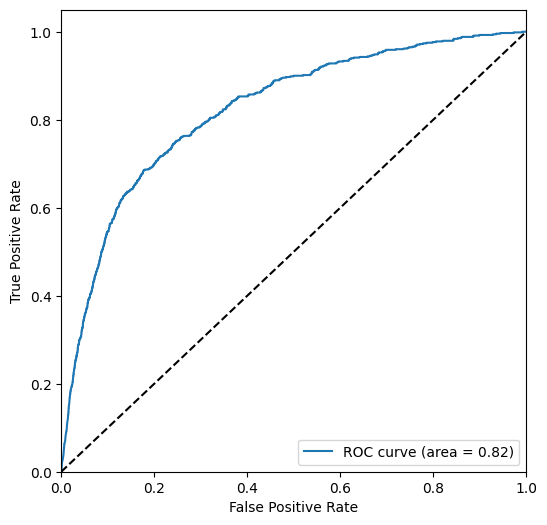

In [494]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [496]:
print(classification_report(encoded_train['claim_status'], y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     44914
           1       0.00      0.00      0.00       680

    accuracy                           0.99     45594
   macro avg       0.49      0.50      0.50     45594
weighted avg       0.97      0.99      0.98     45594



In [498]:
def classification_metrics(y_true, y_pred_prob, cutoff = 0.5):
    y_pred = (y_pred_prob > cutoff).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    precision_1 = cm[1,1] / (cm[1,1] + cm[0,1])
    precision_0 = cm[0,0] / (cm[0,0] + cm[1,0])
    recall_1 = cm[1,1] / (cm[1,1] + cm[1,0])
    recall_0 = cm[0,0] / (cm[0,0] + cm[0,1])
    f1_score_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)
    f1_score_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)
    # averages of the metrics for both classes
    balanced_accuracy = (recall_0 + recall_1) / 2
    balanced_precision = (precision_0 + precision_1)/2
    balanced_f1 = (f1_score_0 + f1_score_1) / 2

    return {'AUROC': roc_auc, 'Accuracy': accuracy, 'Precision 1': precision_1,
            'Precision 0': precision_0, 'Recall 1': recall_1, 'Recall 0': recall_0,
            'F1 Score 1': f1_score_1, 'F1 Score 0': f1_score_0, 'Balanced Accuracy': balanced_accuracy,
            'Balanced precision': balanced_precision, 'Balanced F1': balanced_f1}

In [502]:
classification_metrics(y_train, logit_model1.predict_proba(X_train)[:, 1])

{'AUROC': 0.8216641476914051,
 'Accuracy': 0.9850857568978374,
 'Precision 1': nan,
 'Precision 0': 0.9850857568978374,
 'Recall 1': 0.0,
 'Recall 0': 1.0,
 'F1 Score 1': nan,
 'F1 Score 0': 0.9924868519909842,
 'Balanced Accuracy': 0.5,
 'Balanced precision': nan,
 'Balanced F1': nan}

In [504]:
thresholds = np.arange(0, 1, 0.05)

# now we will calculate the metrics for each threshold
for t in thresholds:
    metrics = classification_metrics(y_train, logit_model1.predict_proba(X_train)[:,1], t)

    # Lets add the current result to the results dataframe
    # adding t as the first column
    if t == 0:
        results = pd.DataFrame(metrics, index=[t])
    else:
        results.loc[t] = metrics

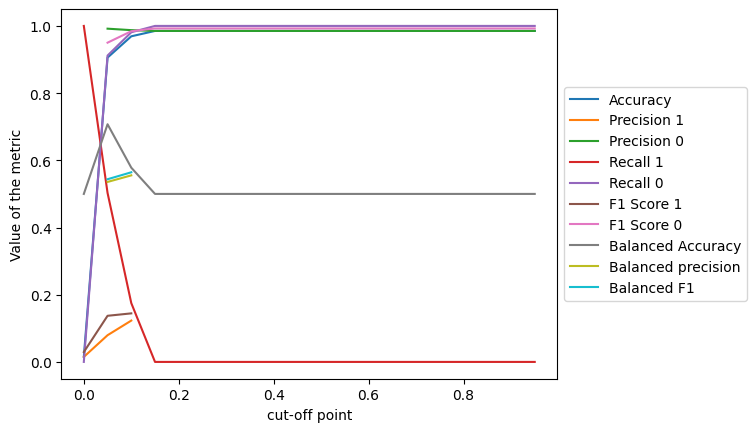

In [506]:
results.drop('AUROC', axis=1).plot()
# put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('cut-off point')
plt.ylabel('Value of the metric')
plt.show()

In [508]:
temp_train = encoded_train.copy()
temp_test = encoded_test.copy()

In [510]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target
X = temp_train.drop('claim_status', axis=1)
y = temp_train['claim_status']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

temp_train_smote = X_resampled.copy()
temp_train_smote['claim_status'] = y_resampled

In [516]:
temp_train_smote.claim_status.value_counts()

claim_status
0    44914
1    44914
Name: count, dtype: int64

In [530]:
X_train = temp_train_smote.drop('claim_status', axis=1)
y_train = temp_train_smote['claim_status']

logit_model3 = LogisticRegression(
    penalty=None
)

logit_model3.fit(X_train, y_train)

LogisticRegression(penalty=None)

In [532]:
logit_model3.predict_proba(X_train)

array([[9.99980566e-01, 1.94336376e-05],
       [9.66059074e-01, 3.39409256e-02],
       [9.52659437e-01, 4.73405630e-02],
       ...,
       [5.21208556e-08, 9.99999948e-01],
       [9.48442324e-01, 5.15576759e-02],
       [1.06223860e-05, 9.99989378e-01]])

In [526]:
y_pred_probs = logit_model3.predict_proba(X_train)[:, 1]
y_pred = logit_model3.predict(X_train)
cm = confusion_matrix(temp_train_smote['claim_status'], y_pred)
fpr, tpr, _ = roc_curve(temp_train_smote['claim_status'], y_pred_probs)
roc_auc = auc(fpr, tpr)
print('Confusion Matrix:')
print(cm)
print('Area Under the Curve:', roc_auc)

Confusion Matrix:
[[41876  3038]
 [ 3214 41700]]
Area Under the Curve: 0.9783771603177194


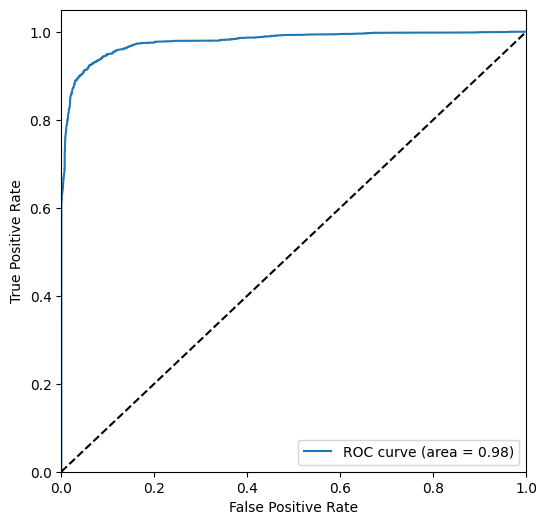

In [524]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [534]:
'''
Only resample the training data — never the test data.

Test data should stay untouched to fairly evaluate real-world performance
'''

'\nOnly resample the training data — never the test data.\n\nTest data should stay untouched to fairly evaluate real-world performance\n'

In [536]:
smote_train_df = temp_train_smote.copy()

In [538]:
smote_train_df.head()

,person_age,trip_length,person_gender_08f27188,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_a,entity_type_type_b,agent_id_Other,agent_id_agt_0001,agent_id_agt_0002,...,product_id_Other,product_id_SecurePlan Annual Lite,product_id_SecurePlan Flex,product_id_SecurePlan OneWay,product_id_TravelShield Basic,product_id_TravelShield Core,product_id_TravelShield Plus,product_id_TravelShield Value,product_id_TripGuard Cancel,claim_status
0,54,66,0,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,24,3,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,35,62,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,37,4,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,42,17,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [564]:
classification_metrics(y, logit_model3.predict_proba(X)[:, 1])

{'AUROC': 0.781492997074147,
 'Accuracy': 0.9242444181251919,
 'Precision 1': 0.07995154451847365,
 'Precision 0': 0.9901636243261137,
 'Recall 1': 0.38823529411764707,
 'Recall 0': 0.9323596206082736,
 'F1 Score 1': 0.13259668508287292,
 'F1 Score 0': 0.9603926335343899,
 'Balanced Accuracy': 0.6602974573629603,
 'Balanced precision': 0.5350575844222937,
 'Balanced F1': 0.5464946593086314}

In [548]:
classification_metrics(y, logit_model3.predict_proba(X)[:, 1], 0.16)

{'AUROC': 0.781492997074147,
 'Accuracy': 0.7887879984208448,
 'Precision 1': 0.04761423372422159,
 'Precision 0': 0.9941459862192594,
 'Recall 1': 0.6926470588235294,
 'Recall 0': 0.7902435766130828,
 'F1 Score 1': 0.08910329171396139,
 'F1 Score 0': 0.8805448050014886,
 'Balanced Accuracy': 0.741445317718306,
 'Balanced precision': 0.5208801099717405,
 'Balanced F1': 0.48482404835772497}

In [554]:
thresholds = np.arange(0, 1, 0.05)

# now we will calculate the metrics for each threshold
for t in thresholds:
    metrics = classification_metrics(y, logit_model3.predict_proba(X)[:,1], t)

    # Lets add the current result to the results dataframe
    # adding t as the first column
    if t == 0:
        results = pd.DataFrame(metrics, index=[t])
    else:
        results.loc[t] = metrics

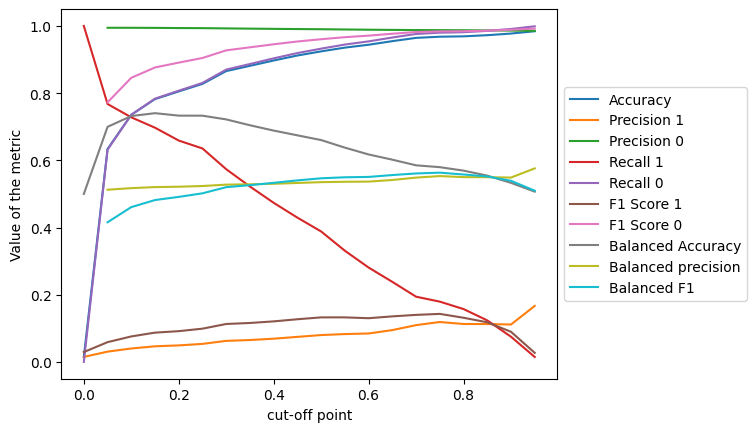

In [556]:
results.drop('AUROC', axis=1).plot()
# put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('cut-off point')
plt.ylabel('Value of the metric')
plt.show()

In [566]:
cv5 = KFold(n_splits = 5, 
            shuffle = True,
            random_state = 123)

In [574]:
X_train = encoded_train.drop('claim_status', axis=1)
y_train = encoded_train['claim_status']

X_test = encoded_test.drop('claim_status', axis=1)
y_test = encoded_test['claim_status']

In [580]:
math.sqrt(len(encoded_train))

213.52751579129094

In [582]:
knn_model1 = KNeighborsClassifier(n_neighbors = 213)
knn_model1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=213)

In [584]:
knn_model1_fitted = knn_model1.predict(X_train)

# see the classification report
print(classification_report(y_train, knn_model1_fitted))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     44914
           1       0.00      0.00      0.00       680

    accuracy                           0.99     45594
   macro avg       0.49      0.50      0.50     45594
weighted avg       0.97      0.99      0.98     45594



In [590]:
y_pred_probs = knn_model1.predict_proba(X_train)[:, 1]
y_pred = knn_model1.predict(X_train)
cm = confusion_matrix(encoded_train['claim_status'], y_pred)
fpr, tpr, _ = roc_curve(encoded_train['claim_status'], y_pred_probs)
roc_auc = auc(fpr, tpr)
print('Confusion Matrix:')
print(cm)
print('Area Under the Curve:', roc_auc)

Confusion Matrix:
[[44914     0]
 [  680     0]]
Area Under the Curve: 0.806165573946549


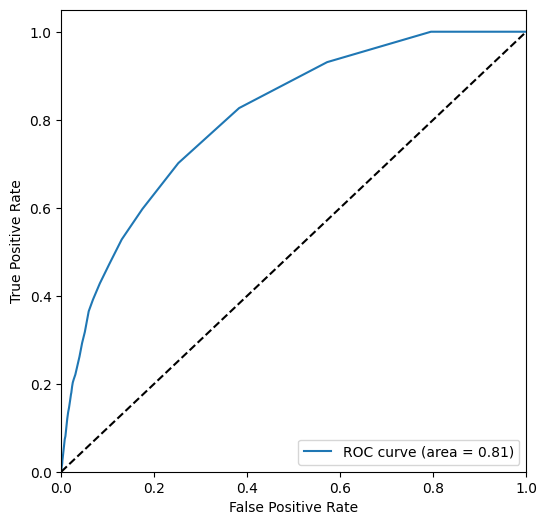

In [592]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [594]:
# let's assume k=3

knn_model2 = KNeighborsClassifier(n_neighbors=3)
knn_model2.fit(X_train, y_train)

knn_model2_fitted = knn_model2.predict(X_train)
knn_model2_predictions = knn_model2.predict(X_test)

# let's see the classification reports
print("Results in the training sample:")
print(classification_report(y_train, knn_model2_fitted))
print("Results in the test sample:")
print(classification_report(y_test, knn_model2_predictions))

Results in the training sample:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     44914
           1       0.48      0.04      0.08       680

    accuracy                           0.99     45594
   macro avg       0.73      0.52      0.54     45594
weighted avg       0.98      0.99      0.98     45594

Results in the test sample:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11245
           1       0.08      0.01      0.01       154

    accuracy                           0.99     11399
   macro avg       0.53      0.50      0.50     11399
weighted avg       0.97      0.99      0.98     11399



In [596]:
y_pred_probs = knn_model2.predict_proba(X_train)[:, 1]
y_pred = knn_model2.predict(X_train)
cm = confusion_matrix(encoded_train['claim_status'], y_pred)
fpr, tpr, _ = roc_curve(encoded_train['claim_status'], y_pred_probs)
roc_auc = auc(fpr, tpr)
print('Confusion Matrix:')
print(cm)
print('Area Under the Curve:', roc_auc)

Confusion Matrix:
[[44881    33]
 [  650    30]]
Area Under the Curve: 0.9070318700575479


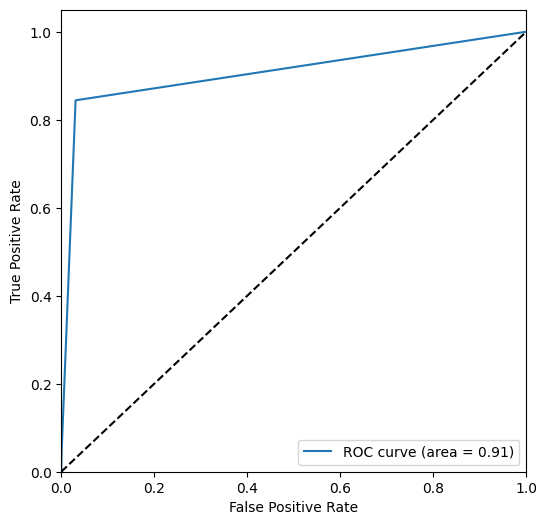

In [598]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [612]:
X_train = smote_train_df.drop('claim_status', axis=1)
y_train = smote_train_df['claim_status']

X_test = encoded_test.drop('claim_status', axis=1)
y_test = encoded_test['claim_status']

In [602]:
# let's assume k=3

knn_model3 = KNeighborsClassifier(n_neighbors=1)
knn_model3.fit(X_train, y_train)

knn_model3_fitted = knn_model3.predict(X_train)
knn_model3_predictions = knn_model3.predict(X_test)

# let's see the classification reports
print("Results in the training sample:")
print(classification_report(y_train, knn_model3_fitted))
print("Results in the test sample:")
print(classification_report(y_test, knn_model3_predictions))

Results in the training sample:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     44914
           1       0.99      0.81      0.89     44914

    accuracy                           0.90     89828
   macro avg       0.92      0.90      0.90     89828
weighted avg       0.92      0.90      0.90     89828

Results in the test sample:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11245
           1       0.03      0.05      0.03       154

    accuracy                           0.96     11399
   macro avg       0.51      0.51      0.51     11399
weighted avg       0.97      0.96      0.97     11399



In [608]:
y_pred_probs = knn_model3.predict_proba(X_train)[:, 1]
y_pred = knn_model3.predict(X_train)
cm = confusion_matrix(smote_train_df['claim_status'], y_pred)
fpr, tpr, _ = roc_curve(smote_train_df['claim_status'], y_pred_probs)
roc_auc = auc(fpr, tpr)
print('Confusion Matrix:')
print(cm)
print('Area Under the Curve:', roc_auc)

Confusion Matrix:
[[44657   257]
 [ 8399 36515]]
Area Under the Curve: 0.903638063855368


In [614]:
X_train = encoded_train.drop('claim_status', axis=1)
y_train = encoded_train['claim_status']

X_test = encoded_test.drop('claim_status', axis=1)
y_test = encoded_test['claim_status']

### Hyperparameter tuning for KNN 

In [625]:
# define the range of k values using odd numbers from 1 to 99
k_values = list(range(1, 216, 2))

# create an object with validation definition
cv5 = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 123
)

knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), # Scaling of data
    ('knn', KNeighborsClassifier()) # KNN classifier
])

param_grid = {
    'knn__n_neighbors': k_values, # number of neighbors
    # also check if the method of weighing neighbors has an impact on the result
    'knn__weights': ['uniform', 'distance']
}

# define GridSearchCV object
knn_grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv = cv5,
    scoring = 'roc_auc',
    n_jobs = -1
)

In [621]:
knn_grid_search.fit(X_train, y_train)

# Best parameters
print('Best parameters:', knn_grid_search.best_params_)
print('Best AUROC value:', knn_grid_search.best_score_)

Best parameters: {'knn__n_neighbors': 97, 'knn__weights': 'uniform'}
Best AUROC value: 0.7798642245252193


<Axes: xlabel='param_knn__n_neighbors', ylabel='mean_test_score'>

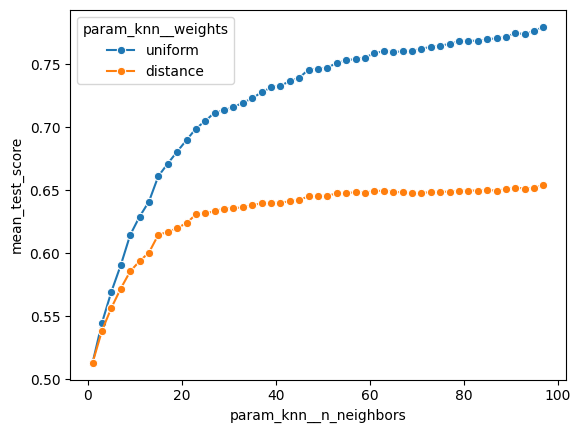

In [623]:
# converting results to DataFrame
knn_grid_search_df = pd.DataFrame(knn_grid_search.cv_results_)

sns.lineplot(
    x = knn_grid_search_df['param_knn__n_neighbors'],
    y = knn_grid_search_df['mean_test_score'],
    hue = knn_grid_search_df['param_knn__weights'],
    marker = 'o'
)


In [627]:
knn_grid_search.fit(X_train, y_train)

# Best parameters
print('Best parameters:', knn_grid_search.best_params_)
print('Best AUROC value:', knn_grid_search.best_score_)

Best parameters: {'knn__n_neighbors': 215, 'knn__weights': 'uniform'}
Best AUROC value: 0.798986916561637


<Axes: xlabel='param_knn__n_neighbors', ylabel='mean_test_score'>

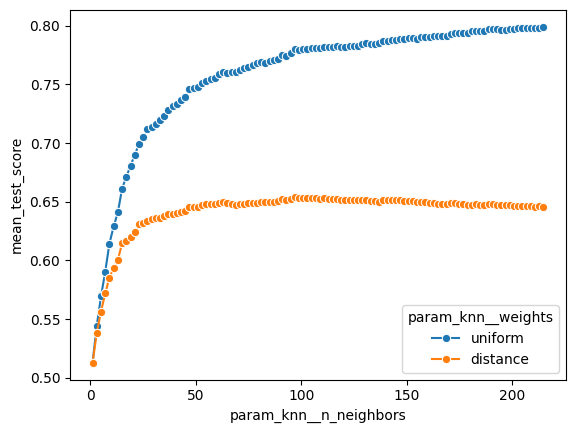

In [629]:
# converting results to DataFrame
knn_grid_search_df = pd.DataFrame(knn_grid_search.cv_results_)

sns.lineplot(
    x = knn_grid_search_df['param_knn__n_neighbors'],
    y = knn_grid_search_df['mean_test_score'],
    hue = knn_grid_search_df['param_knn__weights'],
    marker = 'o'
)

In [644]:
best_knn = knn_grid_search.best_estimator_

In [646]:
best_knn

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=215))])

In [639]:
# Save dataframes
with open('df_train_insurance.pkl', 'wb') as f:
    pickle.dump(df_train, f)
with open('encoded_train_insurance.pkl', 'wb') as f:
    pickle.dump(encoded_train, f)
with open('df_test_insurance.pkl', 'wb') as f:
    pickle.dump(df_test, f)
with open('encoded_test_insurance.pkl', 'wb') as f:
    pickle.dump(encoded_test, f)
with open('df_insurance.pkl', 'wb') as f:
    pickle.dump(df, f)

In [648]:
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model2, f)
with open('logit_model.pkl', 'wb') as f:
    pickle.dump(logit_model1, f)
with open('best_knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn, f)

### Applying models on Test Sample of main DF

In [652]:
y_test_pred = best_knn.predict(X_test)
y_test_probs = best_knn.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)
print("AUC (Test):", roc_auc)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11245
           1       0.00      0.00      0.00       154

    accuracy                           0.99     11399
   macro avg       0.49      0.50      0.50     11399
weighted avg       0.97      0.99      0.98     11399

Confusion Matrix:
[[11245     0]
 [  154     0]]
AUC (Test): 0.8064617463461394


In [656]:
y_test_pred = logit_model1.predict(X_test)
y_test_probs = logit_model1.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)
print("AUC (Test):", roc_auc)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11245
           1       0.00      0.00      0.00       154

    accuracy                           0.99     11399
   macro avg       0.49      0.50      0.50     11399
weighted avg       0.97      0.99      0.98     11399

Confusion Matrix:
[[11245     0]
 [  154     0]]
AUC (Test): 0.8258028099068562


In [659]:
y_test_pred = logit_model3.predict(X_test)
y_test_probs = logit_model3.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)
print("AUC (Test):", roc_auc)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11245
           1       0.06      0.32      0.10       154

    accuracy                           0.92     11399
   macro avg       0.53      0.63      0.53     11399
weighted avg       0.98      0.92      0.95     11399

Confusion Matrix:
[[10469   776]
 [  104    50]]
AUC (Test): 0.7903555981590664


In [665]:
# X_train = encoded_train.drop(
#     ['claim_status'], axis=1
# )
# y_train = encoded_train['claim_status']

# logit_model1 = LogisticRegression(
#     penalty=None
# )

# logit_model1.fit(X_train, y_train)

In [667]:
file_path = Path('data/insurance_test.csv')

In [669]:
test = pd.read_csv(file_path, sep=',')

In [673]:
test.head()

,reward,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
0,84.316320,9b2d5b46,type_a,web,2,agt_0001,0.009257,96d6c6df,31,ireland,-141.716239,DriveSafe Rental Addon,73
1,45.884363,9b2d5b46,type_a,web,0,agt_0001,0.108049,96d6c6df,29,australia,82.225268,DriveSafe Rental Addon,25
2,0.000000,9b2d5b46,type_a,web,2,agt_0004,0.108814,50b3e71e,26,indonesia,10.247118,TripGuard Cancel,6
3,29.363482,f67ab10a,type_b,web,1,agt_0002,0.215505,7b5dbb09,32,france,83.483247,TravelShield Value,73
4,12.440951,08f27188,type_b,web,0,agt_0005,0.194798,99ede4e4,26,singapore,46.679372,TravelShield Plus,32


In [675]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                6333 non-null   float64
 1   person_gender         6333 non-null   object 
 2   entity_type           6333 non-null   object 
 3   channel               6333 non-null   object 
 4   support_interactions  6333 non-null   int64  
 5   agent_id              6333 non-null   object 
 6   customer_score        6333 non-null   float64
 7   entity_a              6333 non-null   object 
 8   person_age            6333 non-null   int64  
 9   location              6333 non-null   object 
 10  revenue               6333 non-null   float64
 11  product_id            6333 non-null   object 
 12  trip_length           6333 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 643.3+ KB


In [677]:
df_train.columns

Index(['claim_status', 'person_gender', 'entity_type', 'agent_id', 'entity_a',
       'person_age', 'location', 'product_id', 'trip_length'],
      dtype='object')

In [679]:
test_copy = test.copy()

In [773]:
# test = test_copy.copy()

In [785]:
test = test[['person_gender', 'entity_type', 'agent_id', 'entity_a', 
             'person_age', 'location', 'product_id', 'trip_length']]

In [787]:
categorical_variables = test.select_dtypes('object').columns
numerical_variables = test.select_dtypes(include=[np.number]).columns

In [689]:
# test_encoded = pd.get_dummies(
#     test, 
#     columns=categorical_variables, 
#     drop_first=False,
#     dtype = int
# )

In [695]:
# for var in categorical_variables:
#     value_counts = test[var].value_counts()
#     levels_to_replace = value_counts[value_counts < 570].index  # 1% of sample size
#     test[var] = test[var].replace(levels_to_replace, 'Other')

In [775]:
# Group agent_id & entity_a with counts < 500 into 'Other'
for col in ['agent_id']:
    counts = test[col].value_counts()
    to_other = counts[counts < 76].index
    test[col] = test[col].replace(to_other, 'Other')

In [777]:
for col in ['entity_a']:
    counts = test[col].value_counts()
    to_other = counts[counts < 76].index
    test[col] = test[col].replace(to_other, 'Other')

In [699]:
# # Bin person_age 60+ into '60+'
# test['person_age'] = test['person_age'].apply(lambda x: '60+' if x >= 60 else x)

In [779]:
# Group location with counts < 900 (from 'united kingdom' down) into 'Other'
loc_counts = test['location'].value_counts()
loc_to_other = loc_counts[loc_counts < 140].index
test['location'] = test['location'].replace(loc_to_other, 'Other')

In [781]:
# Group product_id with counts < 1000 into 'Other'
prod_counts = test['product_id'].value_counts()
prod_to_other = prod_counts[prod_counts < 110].index
test['product_id'] = test['product_id'].replace(prod_to_other, 'Other')

In [707]:
# def bin_trip_length(x):
#     if x > 90:
#         return '90+'
#     elif 1 <= x <= 60:
#         return x
#     else:
#         # For zero or invalid trip lengths, decide what to do, e.g.:
#         return x  # or return np.nan if you want to treat them as missing

In [749]:
# test['trip_length'] = test['trip_length'].apply(bin_trip_length)

In [751]:
# # Replace '60+' with 60 and convert to numeric
# test['person_age'] = test['person_age'].replace('60+', 60).astype(int)
# test['trip_length'] = test['trip_length'].replace('90+', 90).astype(int)

In [789]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   person_gender  6333 non-null   object
 1   entity_type    6333 non-null   object
 2   agent_id       6333 non-null   object
 3   entity_a       6333 non-null   object
 4   person_age     6333 non-null   int64 
 5   location       6333 non-null   object
 6   product_id     6333 non-null   object
 7   trip_length    6333 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 395.9+ KB


In [791]:
test_encoded = pd.get_dummies(
    test, 
    columns=categorical_variables, 
    drop_first=False,
    dtype = int
)

In [793]:
test_encoded.shape

(6333, 48)

In [795]:
encoded_train.shape

(45594, 49)

In [797]:
encoded_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45594 entries, 40310 to 56422
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   claim_status                       45594 non-null  int64
 1   person_age                         45594 non-null  int32
 2   trip_length                        45594 non-null  int32
 3   person_gender_08f27188             45594 non-null  int32
 4   person_gender_9b2d5b46             45594 non-null  int32
 5   person_gender_f67ab10a             45594 non-null  int32
 6   entity_type_type_a                 45594 non-null  int32
 7   entity_type_type_b                 45594 non-null  int32
 8   agent_id_Other                     45594 non-null  int32
 9   agent_id_agt_0001                  45594 non-null  int32
 10  agent_id_agt_0002                  45594 non-null  int32
 11  agent_id_agt_0004                  45594 non-null  int32
 12  agent_id_agt_0005  

In [799]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   person_age                         6333 non-null   int64
 1   trip_length                        6333 non-null   int64
 2   person_gender_08f27188             6333 non-null   int32
 3   person_gender_9b2d5b46             6333 non-null   int32
 4   person_gender_f67ab10a             6333 non-null   int32
 5   entity_type_type_a                 6333 non-null   int32
 6   entity_type_type_b                 6333 non-null   int32
 7   agent_id_Other                     6333 non-null   int32
 8   agent_id_agt_0001                  6333 non-null   int32
 9   agent_id_agt_0002                  6333 non-null   int32
 10  agent_id_agt_0004                  6333 non-null   int32
 11  agent_id_agt_0005                  6333 non-null   int32
 12  agent_id_agt_0006   

In [747]:
# # pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

In [801]:
# test.location.value_counts()

In [807]:
# test_preds = best_knn.predict(test_encoded)

In [809]:
test = test_copy.copy()

In [811]:
test = test[['person_gender', 'entity_type', 'agent_id', 'entity_a', 
             'person_age', 'location', 'product_id', 'trip_length']]

In [813]:
test_encoded = pd.get_dummies(
    test, 
    columns=categorical_variables, 
    drop_first=False,
    dtype = int
)

In [815]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Columns: 157 entries, person_age to product_id_TripGuard TicketCover
dtypes: int32(155), int64(2)
memory usage: 3.8 MB


In [821]:
extract_columns = encoded_train.columns.drop('claim_status').tolist()

In [823]:
# Keep only columns from train set that are in test_encoded
test_encoded = test_encoded.reindex(columns=extract_columns, fill_value=0)

In [825]:
test_encoded.head()

,person_age,trip_length,person_gender_08f27188,person_gender_9b2d5b46,person_gender_f67ab10a,entity_type_type_a,entity_type_type_b,agent_id_Other,agent_id_agt_0001,agent_id_agt_0002,...,product_id_DriveSafe Rental Addon,product_id_Other,product_id_SecurePlan Annual Lite,product_id_SecurePlan Flex,product_id_SecurePlan OneWay,product_id_TravelShield Basic,product_id_TravelShield Core,product_id_TravelShield Plus,product_id_TravelShield Value,product_id_TripGuard Cancel
0,31,73,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,29,25,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,26,6,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,32,73,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,26,32,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [827]:
test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   person_age                         6333 non-null   int64
 1   trip_length                        6333 non-null   int64
 2   person_gender_08f27188             6333 non-null   int32
 3   person_gender_9b2d5b46             6333 non-null   int32
 4   person_gender_f67ab10a             6333 non-null   int32
 5   entity_type_type_a                 6333 non-null   int32
 6   entity_type_type_b                 6333 non-null   int32
 7   agent_id_Other                     6333 non-null   int64
 8   agent_id_agt_0001                  6333 non-null   int32
 9   agent_id_agt_0002                  6333 non-null   int32
 10  agent_id_agt_0004                  6333 non-null   int32
 11  agent_id_agt_0005                  6333 non-null   int32
 12  agent_id_agt_0006   

In [829]:
test_preds = best_knn.predict(test_encoded)

In [831]:
test_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [833]:
test['claim_status_pred'] = test_preds

In [835]:
test.head()

,person_gender,entity_type,agent_id,entity_a,person_age,location,product_id,trip_length,claim_status_pred
0,9b2d5b46,type_a,agt_0001,96d6c6df,31,ireland,DriveSafe Rental Addon,73,0
1,9b2d5b46,type_a,agt_0001,96d6c6df,29,australia,DriveSafe Rental Addon,25,0
2,9b2d5b46,type_a,agt_0004,50b3e71e,26,indonesia,TripGuard Cancel,6,0
3,f67ab10a,type_b,agt_0002,7b5dbb09,32,france,TravelShield Value,73,0
4,08f27188,type_b,agt_0005,99ede4e4,26,singapore,TravelShield Plus,32,0


### Model Predictions on Test Dataset

Using the trained KNN model, new predictions for the target variable `claim_status` were generated on the test dataset. These predictions were added as a new column named `claim_status_pred` to the original (non-encoded) test DataFrame.

This column contains the predicted values of `claim_status` based on the KNN model.


In [838]:
# Save dataframes
with open('final_test_insurance.pkl', 'wb') as f:
    pickle.dump(test, f)
with open('final_test_encoded_insurance.pkl', 'wb') as f:
    pickle.dump(test_encoded, f)